# Relax Inc.

**Imports**

In [458]:
import re
import string
import requests
import os
import sys
import statistics
from scipy.stats import skew
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from pandas import DataFrame
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.pyplot import figure
from datetime import timedelta
%matplotlib inline
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

import datetime
import time
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

%reload_ext watermark


**Goal** 

Define an `adopted user` as:
   1. A user who has logged into the product on three separate days in at least one sevenday period
   2. Identify which factors predict future user adoption


**Presentation**

**Please send us a brief writeup of your findings (the more concise, the better no more than one page), along with any of the below that can help us understand your approach**:    
   * Summary Tables;
   * Graphs;
   * Code; or
   * Queries

**Please note any factors you considered or investigation you did, even if they did not pan out. Feel free to identify any further research or data you think would be valuable.**

<i>We suggest spending 12 hours on this, but you're welcome to spend more or less.</i>


**Upload Data**

In [459]:
cd

C:\Users\rands


In [460]:
engagement = pd.read_csv('./SB #26 Effective Interviewing for Data Scientists/relax_challenge/takehome_user_engagement.csv')
print('User Engagement Upload | Complete')

User Engagement Upload | Complete


In [461]:
users = pd.read_csv('./SB #26 Effective Interviewing for Data Scientists/relax_challenge/takehome_users.csv')
print('Take Home Users Upload | Complete')

Take Home Users Upload | Complete


**Data Explained** | `engagement`

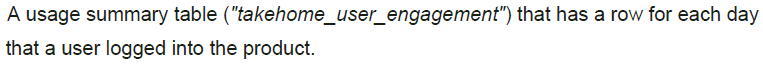

In [462]:
engagement.head(2)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1


In [463]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


Observations below:
   * No null values
   * `time_stamp` should be a date time object

In [464]:
# converting time_stamp to date time object
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])

In [465]:
engagement.info(['time_stamp']) # engagement['time_stamp']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [466]:
# visited is a clean 1
engagement['visited'].unique()

array([1], dtype=int64)

In [467]:
# let's check the otheres
users_u = engagement['user_id'].nunique()

print('We\'ve got {} unique users with {} observations'.format("{:,}".format(users_u),
                                                              "{:,}".format(engagement['visited'].sum())))

We've got 8,823 unique users with 207,917 observations


As our goal is to determine if a user logged in on three (3) separate days in at least one sevenday (7) period; **we will then call them an adopted user.**

We will call this a variable | `ad_user`

In [468]:
# setting up the infastructure
def logins_in_days(df, days=7, logins=3):
    df['date'] = df['time_stamp'].dt.date
    usage = df['date'].diff(periods=logins-1)
    return any(usage <= timedelta(days=days))

In [469]:
# sending it a seperate dataframe
ad_user_df = pd.DataFrame([])
ad_user_df = pd.DataFrame(engagement.groupby('user_id').apply(logins_in_days))
ad_user_df.columns = ['ad_user']

In [470]:
ad_user_t = (sum(ad_user_df['ad_user']))
ad_user_p = '{:,.2f}%'.format(((ad_user_t / users_u)) * 100)
print('Out of the {} users, {} were adopted representing {} in total'.format(users_u,ad_user_p,ad_user_t))

Out of the 8823 users, 18.77% were adopted representing 1656 in total


**Complete**; we will send to Exploratory Data Analysis (EDA) but first review the `users` data frame.

**Data Explained** | `users`

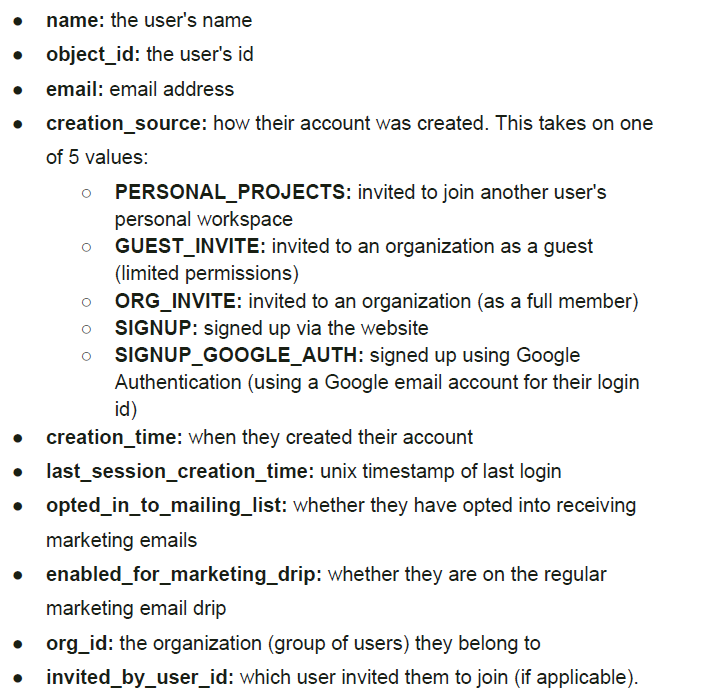

In [471]:
users.head(2)

,object_id,creation_time,name,email,creation_source,creation_source_#,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,4/22/2014 3:53,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,1.398139e+09,1,0,11,10803.0
1,4,5/21/2013 8:09,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1,1.369210e+09,0,0,1,5151.0


In [472]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   creation_source_#           12000 non-null  int64  
 6   last_session_creation_time  8823 non-null   float64
 7   opted_in_to_mailing_list    12000 non-null  int64  
 8   enabled_for_marketing_drip  12000 non-null  int64  
 9   org_id                      12000 non-null  int64  
 10  invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(5), object(4)
memory usage: 1.0+ MB


Convert the `creation_time` & `last_session_creation_time` to date time objects; the second of which is said to be in unix format.

In [473]:
# converting creation_time to date time object
users['creation_time'] = pd.to_datetime(users['creation_time'])

Let's take a look at `last_session_creation_time` on a seperate dataframe to double confirm the information about it's unix format is correct.

In [474]:
# setting up a temp dataframe to mitigate disruption on the orginal
users_temp = pd.DataFrame([])
users_temp = users.copy()

In [475]:
# converting the last_session_creation_time to date time
users_temp['last_session_creation_time'] = pd.to_datetime(users_temp['last_session_creation_time'],unit='s')

Let's now assess adopted users herein.

In [476]:
# making sure we can play with time stamps for connecting engagement with users
engagement.time_stamp = pd.to_datetime(engagement.time_stamp)
engagement = engagement.set_index('time_stamp', drop= True)

# here we will run over the difference between the 1 to 3 days
def adopted(x):    
    a = 0
    def_temp = engagement.loc[engagement['user_id'] == x]
    def_temp = def_temp.resample('D').mean().dropna()

    for i in range(len(def_temp)-2): # making sure this stays in the bounds
        if def_temp.index[i + 2] - def_temp.index[i] <= timedelta(days=7):
            a = 1
            break
        else:
            a = 0
    return a


In [477]:
# connect engagement with users
users_temp['u_adopted'] = users_temp['object_id'].apply(adopted)

Let's check to see if it makes sense; we will look at the difference between:
   * **last_session_creation_time** <i>minus</i> **creation_time**

In [478]:
users_temp['diff'] = (users_temp['last_session_creation_time'] - users_temp['creation_time'])

In [479]:
# pulling only the number of days
i = 0
dys_diff = []
for i in range(len(users_temp)):
    app = users_temp['diff'][i].days
    i += 1
    dys_diff.append(app)

In [480]:
#sending to a pandas data frame
dys_diff_df_col = pd.DataFrame([])
dys_diff_df_col = pd.DataFrame([dys_diff])
dys_diff_df_col = dys_diff_df_col.T
dys_diff_df_col.columns = ['dys_diff']

In [481]:
print(type(dys_diff_df_col), len(dys_diff_df_col))

<class 'pandas.core.frame.DataFrame'> 12000


In [482]:
# sending it the temp user's data frame
users_temp['dys_diff'] = dys_diff_df_col['dys_diff']

In [483]:
users_temp.head(3)

,object_id,creation_time,name,email,creation_source,creation_source_#,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,u_adopted,diff,dys_diff
0,1,2014-04-22 03:53:00,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,2014-04-22 03:53:30,1,0,11,10803.0,0,0 days 00:00:30,0.0
1,4,2013-05-21 08:09:00,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1,2013-05-22 08:09:28,0,0,1,5151.0,0,1 days 00:00:28,1.0
2,5,2013-01-17 10:14:00,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1,2013-01-22 10:14:20,0,0,193,5240.0,0,5 days 00:00:20,5.0


Text(0.5, 1.0, 'Difference in Days between Account Created & the Last Login')

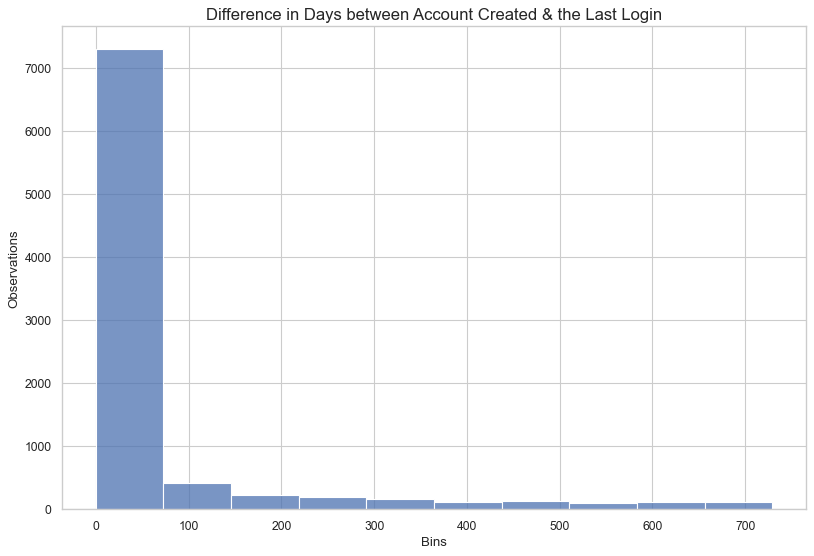

In [484]:
figure(figsize=(12,8), dpi=80)
sns.histplot(data=users_temp, x="dys_diff", bins=10)
plt.xlabel('Bins', fontsize=12)
plt.ylabel('Observations', fontsize=12)
plt.title('Difference in Days between Account Created & the Last Login', fontsize=15)

Looks ok; we convert the `last_session_creation_time` to a **date time** object.

In [488]:
users['last_session_creation_time'] = users_temp['last_session_creation_time']

Let's also bring in the new variables.

In [491]:
users = pd.concat([users,users_temp['diff'],users_temp['dys_diff'],users_temp['u_adopted']],axis=1,ignore_index=False)

In [493]:
users.head(6)

,object_id,creation_time,name,email,creation_source,creation_source_#,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,diff,dys_diff,u_adopted
0,1,2014-04-22 03:53:00,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,2014-04-22 03:53:30,1,0,11,10803.0,0 days 00:00:30,0.0,0
1,4,2013-05-21 08:09:00,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1,2013-05-22 08:09:28,0,0,1,5151.0,1 days 00:00:28,1.0,0
2,5,2013-01-17 10:14:00,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1,2013-01-22 10:14:20,0,0,193,5240.0,5 days 00:00:20,5.0,0
3,6,2013-12-17 03:37:00,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1,2013-12-19 03:37:06,0,0,197,11241.0,2 days 00:00:06,2.0,0
4,17,2014-04-09 14:39:00,Reynolds Anthony,AnthonyReynolds@jourrapide.com,GUEST_INVITE,1,2014-04-12 14:39:38,1,0,175,1600.0,3 days 00:00:38,3.0,0
5,18,2013-08-24 00:26:00,Gregersen Celina,CelinaAGregersen@jourrapide.com,GUEST_INVITE,1,NaT,0,0,2,3153.0,NaT,NaN,0


In [494]:
lsct_null = users['last_session_creation_time'].isnull().sum()
lsct_p = '{:,.2f}%'.format(round(((lsct_null/len(users))*100),1))
print('The last_session_creation_time has {} null values; {} of the dataframe; we will remove them before modeling.'.format(lsct_null,lsct_p))

The last_session_creation_time has 3177 null values; 26.50% of the dataframe; we will remove them before modeling.


In [495]:
# setting up a new dataframe for modeling 
users_mod = users.copy()
users_mod.dropna(subset = ["last_session_creation_time"], inplace=True)

In [496]:
# checking to see if it worked
print(users_mod['last_session_creation_time'].isnull().sum(), '| We should have Zero null values')

0 | We should have Zero null values


**Modeling**

We will now turn to our favorite family, the Scikit-learn family, to build out categorical features.

In [498]:
users_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 11999
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype          
---  ------                      --------------  -----          
 0   object_id                   8823 non-null   int64          
 1   creation_time               8823 non-null   datetime64[ns] 
 2   name                        8823 non-null   object         
 3   email                       8823 non-null   object         
 4   creation_source             8823 non-null   object         
 5   creation_source_#           8823 non-null   int64          
 6   last_session_creation_time  8823 non-null   datetime64[ns] 
 7   opted_in_to_mailing_list    8823 non-null   int64          
 8   enabled_for_marketing_drip  8823 non-null   int64          
 9   org_id                      8823 non-null   int64          
 10  invited_by_user_id          4776 non-null   float64        
 11  diff                        8823 non-null 

We will now build out a categorical dataframe.

In [499]:
users_mod_cat = pd.DataFrame([])
users_mod_cat = users_mod[['creation_source', 'opted_in_to_mailing_list',
                           'enabled_for_marketing_drip', 'org_id','invited_by_user_id', 'dys_diff','u_adopted']]

In [500]:
sk_le = LabelEncoder()

org_id_l = sk_le.fit_transform(users_mod['org_id'])
users_mod_cat.org_id = org_id_l

creation_l = sk_le.fit_transform(users_mod['creation_source'])
users_mod_cat.creation_source = creation_l

invited_l = sk_le.fit_transform(users_mod['invited_by_user_id'])
users_mod_cat.org_id = invited_l

In [501]:
users_mod_cat.head(3)

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,dys_diff,u_adopted
0,0,1,0,2023,10803.0,0.0,0
1,0,0,0,966,5151.0,1.0,0
2,0,0,0,983,5240.0,5.0,0


Let's now bring in some other members of the Scikit-learn family to build out a classifier model.

To begin any machine learning exercise we will need to split.

Before we do that, let's check for NaN's.

In [502]:
users_mod_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 11999
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   creation_source             8823 non-null   int32  
 1   opted_in_to_mailing_list    8823 non-null   int64  
 2   enabled_for_marketing_drip  8823 non-null   int64  
 3   org_id                      8823 non-null   int64  
 4   invited_by_user_id          4776 non-null   float64
 5   dys_diff                    8823 non-null   float64
 6   u_adopted                   8823 non-null   int64  
dtypes: float64(2), int32(1), int64(4)
memory usage: 517.0 KB


`invited_by_user_id` has Nulls but this may be important. Let's check what **user_id** numbers we have.

In [503]:
id_uni = users_mod_cat['invited_by_user_id'].nunique()
id_n_max = users_mod_cat['invited_by_user_id'].max()
id_uni_new = id_n_max + 1
print('There\'s {} different user_ids & a max of {} so we\'ll fill Nulls w/ the value of {}'.format(id_uni,id_n_max,id_uni_new))

There's 2229 different user_ids & a max of 11999.0 so we'll fill Nulls w/ the value of 12000.0


In [504]:
users_mod_cat['invited_by_user_id'] = users_mod_cat['invited_by_user_id'].fillna(id_uni_new)

In [505]:
users_mod_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 11999
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   creation_source             8823 non-null   int32  
 1   opted_in_to_mailing_list    8823 non-null   int64  
 2   enabled_for_marketing_drip  8823 non-null   int64  
 3   org_id                      8823 non-null   int64  
 4   invited_by_user_id          8823 non-null   float64
 5   dys_diff                    8823 non-null   float64
 6   u_adopted                   8823 non-null   int64  
dtypes: float64(2), int32(1), int64(4)
memory usage: 517.0 KB


Complete; ready for modeling.

**Modeling**

In any Data Science project, we will first split.

In [506]:
data = users_mod_cat.drop('u_adopted', axis=1)
l = users_mod_cat.u_adopted

X_train, y_train, X_test, y_test = train_test_split(data, l, test_size=0.3, random_state=47)

In [507]:
rands_forest = RandomForestClassifier()

rands_forest.fit(X_train, X_test)

rands_f_score = rands_forest.score(y_train, y_test)

In [508]:
print('The Random Forest Score comes in at {} on the Training Set'.format('{:,.2f}%'.format(round((rands_f_score)*100,2))))

The Random Forest Score comes in at 96.22% on the Training Set


Great but let's take a look at the Test set.

In [509]:
y_pred = rands_forest.predict(y_train)
confused = confusion_matrix(y_test,y_pred)

In [510]:
print('Listed below','\n','\n',classification_report(y_test, y_pred))

Listed below 
 
               precision    recall  f1-score   support

           0       0.97      0.98      0.98      2133
           1       0.91      0.89      0.90       514

    accuracy                           0.96      2647
   macro avg       0.94      0.94      0.94      2647
weighted avg       0.96      0.96      0.96      2647



Hovering ~90%(+) on Precision & Recall suggests we did not over fit.

Let's check which variables are helping the most to classify.

In [518]:
f_rank = pd.DataFrame([])
f_rank['coefficient'] = rands_forest.feature_importances_
f_rank = f_rank.set_index(data.columns)

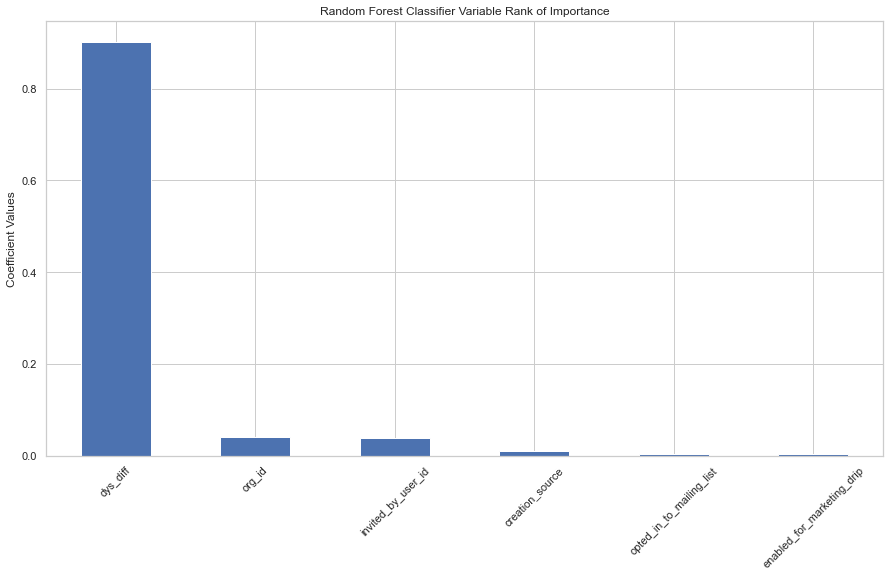

In [522]:
plt.figure(figsize=(15,8))
(f_rank['coefficient']).nlargest(10).plot(kind='bar', x=f_rank.index)
plt.title('Random Forest Classifier Variable Rank of Importance')
plt.ylabel('Coefficient Values')
plt.xticks(rotation=45)
plt.show()

Confirmed that by & large the **`dys_diff` is the most notable contributor to becoming an Adopted User.**

As a reminder, **identifing the factors in which a user becomes an `adopted user` is our goal & an `adopted user` is defined as**:
   1. A user who has logged into the product on three separate days in at least one sevenday period
   2. Identify which factors predict future user adoption

`dys_diff`, meanwhile, is the total number of days (days only) between when `last_session_creation_time` & `creation_time`. To simplified what `dys_diff` means:
   * If the last record of the user is further from when they signed up, they are active

It may be prudent to assume that `dys_diff` was the reason our confusion matrix presented such positive results. Aside from `dys_diff`. `org_id` & `invited_by_user_id` have the only visually noticable help but given their relative size of uniquiness, they may not be as significant of an influence on an `adopted user`.